# Final Project - Hospitalization Prediction for Elderly People

In [1]:
from src import extract_data as data, preprocessing, eda
import pandas as pd


# Data Extraction

* *The Mexican Health and Aging Study* (**MHAS**) is a dataset of household surveys designed to collect information on the health, economic status, and quality of life of older adults.
The survey was conducted over 5 time periods, technically known as **Waves**. 
In addition, there are three study subjects: the respondent (r), the spouse (s), and the household (H). For this study we will use the last wave and the respondent(r).

To access the data for this project, you only need to execute the code below. This will download H_MHAS_c2.sas7bdat file inside the `dataset` folder:

In [ ]:
# Run only once, or if you need to rebuild the original data
df = data.download_dataset()

In [ ]:
print('We have',df.shape[0],'subjects')
print('We have',df.shape[1],'features')
print('Head', df.head())

If you have download the dataset, you only need to execute the code below. 



In [2]:
df = data.load_dataset()

### Features
The dataset `H_MHAS_c2.sas7bdat` has 26839 rows and 5241 features.

All features are divided into the following sections.

- SECTION A: DEMOGRAPHICS, IDENTIFIERS, AND WEIGHTS 
- SECTION B: HEALTH 
- SECTION C: HEALTH CARE UTILIZATION AND INSURANCE 
- SECTION D: COGNITION  
- SECTION E: FINANCIAL AND HOUSING WEALTH 
- SECTION F: INCOME
- SECTION G: FAMILY STRUCTURE 
- SECTION H: EMPLOYMENT HISTORY 
- SECTION I: RETIREMENT 
- SECTION J: PENSION 
- SECTION K: PHYSICAL MEASURES
- SECTION L: ASSISTANCE AND CAREGIVING
- SECTION M: STRESS 
- SECTION O: END OF LIFE PLANNING
- SECTION Q: PSYCHOSOCIAL

# Categorical and Numerical Features 

In [3]:
categorical_vars = df.select_dtypes(include=['object']).columns
numerical_vars = df.select_dtypes(include=['float64']).columns

print('Categorical features ' + str(len(categorical_vars)))
print('Numerical features ' + str(len(numerical_vars)) )


Categorical features 7
Numerical features 5234


# We will save the features with the possible values.

In [ ]:
preprocessing.save_categorical_features_with_values(df, 'features_with_values.txt')

# Extract Data

* In this study, we will focus on the Respondent
* The Householder variable will be removed from data



### Split waves

Our initial approach is to train our model using separate waves. We made this decision because the last three waves took place every two years and there is little data available to helps us bridge that gap, so a cross-sectional cut of the data makes sense as our best option.

In [4]:
wave_5_df = preprocessing.extract_wave_data(df, "5")

print(f'Wave 5 dataframe has the following shape: {wave_5_df.shape}')

Wave 5 dataframe has the following shape: (26839, 1004)


<a id='split-respondents'></a>
### Split respondents

Our initial approach is to train the model using only data from the respondents, as we believe it is the most relevant information to properly train our model; also, given that our MPV requires interaction with the people interested in receiving a hospitalization prediction, we deem it best to ask them questions abouth themselves rather than their spouse or household, as such information might not be available during their interaction with our MVP.

In [5]:
wave_5_respondents_df = preprocessing.extract_respondent_data(wave_5_df)

print(f'Wave 5 respondent-only dataframe has the following shape: {wave_5_respondents_df.shape}')

Wave 5 respondent-only dataframe has the following shape: (26839, 469)


In [ ]:
preprocessing.save_categorical_features_with_values(wave_5_respondents_df, 'wave_5_features_with_values.txt')

# Missing Values

Number of features: 469


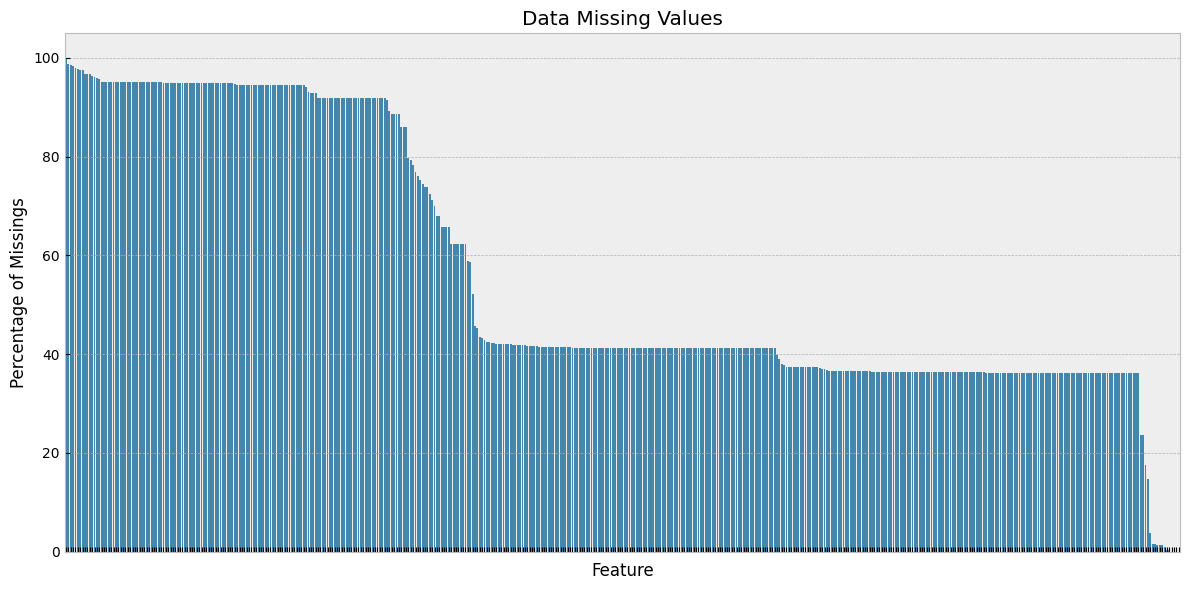

In [7]:
print(f"Number of features: {wave_5_respondents_df.shape[1]}")
eda.plot_missing_values(wave_5_respondents_df)

# Identification of the target variable
* The target variable belongs to *Section C: Health Care Utilization and Insurance* and is labeled **Medical Care Utilization: Hospital** *`rhosp1y`*

* *rhosp1y* indicates whether the respondent reports at least one overnight hospital stay in the last 12 months. RHOSP1Y is coded as 0 if the respondent had no overnight hospital stays, and is coded as 1 if the respondent had at least one overnight hospital stay. 

# Missing Values in target Variable rhosp1y

/home/matias/Documents/AnyoneAI/ProyectoFinal/riesgo-hospitalario-modelado/src/eda.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Column', y='Missing Percentage', data=data, palette='Set2')


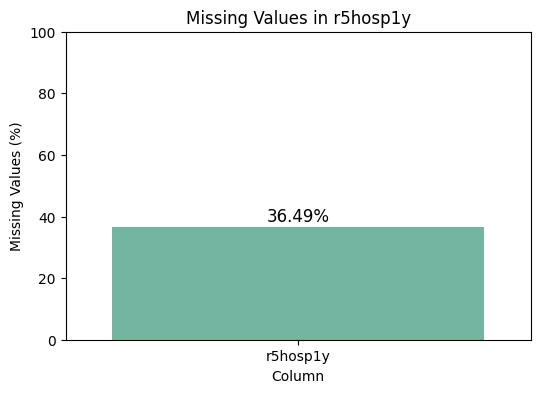

In [10]:
eda.plot_missing_percentage(wave_5_respondents_df, 'r5hosp1y')

<a id='remove-missing-target'></a>
### Remove missing values in target variable

Our first step is to remove all rows containing missing values in our target variable. Why remove them instead of imputate them? Because this is our ground truth: We cannot alter it by somehow estimating missing values from the data. If we attempt to imputate our ground truth with other features, we'd be incorporating information about the data into the target variable, which could very likely lead us to overfit our model.

In [11]:
wave_5_respondents_df = preprocessing.remove_missing_values(wave_5_respondents_df, 'r5hosp1y')

print(f'Shape: {wave_5_respondents_df.shape}')

Shape: (17046, 469)


<a id='drop-high-rate-missing-values-columns'></a>

### Drop columns with a high rate of missing values

We have decided to drop columns with a high missing values ratio (>0.7). A column with such a high proportion of missing values hints at survey unreliability and it doesn't make much sense to imputate missing values when their proportion is higher than existing values.

In [12]:
variables_to_drop = preprocessing.missing_value_ratio(wave_5_respondents_df, 0.7)

# Drop the columns with specified missing values ratio
wave_5_respondents_df = wave_5_respondents_df.drop(columns=variables_to_drop)

# Verify columns were droped. Starting column count is 469
print(f'New column count: {wave_5_respondents_df.shape[1]}')

Variables with a missing value ratio higher than 0.7: ['r5rifcaredpmm', 'r5rarcaren', 'r5rscaredpmm', 'r5ciqscore5', 'r5ciqscore3', 'r5rarcare', 'r5riccarehrm', 'r5rircarehr', 'r5ripfcaren', 'r5ciqscore6', 'r5rfaany', 'r5rscaredpm', 'r5walkhlp', 'r5ciqscore8', 'r5rapfcarehr', 'r5rascaredpm', 'r5rfcaredpm', 'r5ricany', 'r5rfcare', 'r5raccaren', 'r5medhlp', 'r5rascarehr', 'r5rarcarehrm', 'r5prchmem', 'r5rircarehrm', 'r5rfcarehrm', 'r5prmem', 'r5ciqscore14', 'r5rrcaredpm', 'r5rpfcarehrm', 'r5ciqscore12', 'r5rrcarehrm', 'r5riccarehr', 'r5rechrtatt', 'r5rifcaredpm', 'radyear', 'r5ripfcaredpm', 'r5ripfcarehr', 'r5haluc', 'r5rccaredpmm', 'r5rcany', 'r5rarcarehr', 'r5riccare', 'r5rrcaredpmm', 'r5ciqscore16', 'r5rifcare', 'r5rrcaren', 'r5mealhlp', 'r5ciqscore10', 'r5jlasty', 'r5rafcarehrm', 'radmonth', 'r5riccaredpm', 'r5rircaredpm', 'r5rfcarehr', 'r5shophlp', 'r5rafcaredpmm', 'r5reccancr', 'r5ciqscore15', 'r5stroklmt', 'r5raccaredpmm', 'r5riscarehrm', 'r5wander', 'r5toilethlp', 'r5retage', 'r5

In [ ]:
preprocessing.save_categorical_features_with_values(wave_5_respondents_df, 'wave_5_features_out_missing_value.txt')

# Data Preprocessing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values


In [ ]:
print(X)


In [ ]:
print(y)

In [ ]:
columns_list = list(df.columns)
print(columns_list)

num_columns = len(df.columns)
print(f"The dataset contains {num_columns} columns.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Basic Information
print("Basic Info:")
print(df.info())
print("\n")

print("Summary Statistics:")
print(df.describe(include='all'))
print("\n")

# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n")

# Check for duplicate rows
print("Duplicate Rows:")
print(df.duplicated().sum())
print("\n")




In [ ]:

target_column = 'your_target_column'
if target_column in df.columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=target_column, data=df)
    plt.title(f'Target Column Distribution: {target_column}')
    plt.show()